## Full spectral fitting of a passively evolving galaxy;

This notebook will demosntrate how we get redshift of a passively evoluving (i.e. no emission lines) galaxy with NIRISS spectra+photometry and HST photometry.


In [1]:
%matplotlib inline
%load_ext autoreload

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import ascii,fits
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.table import QTable
import astropy.units as u

from astropy import __version__ as asver
asver

'4.0.1.post1'

In [3]:
# https://github.com/mtakahiro/gsf/tree/version1.4
import gsf
print(gsf.__version__)

from gsf.function import get_input
from gsf.gsf import run_gsf_template
from gsf.plot_sed_logA import plot_sed, plot_corner_physparam_frame, plot_corner_physparam_summary
from gsf.plot_sfh_logA import plot_sfh

1.4


### Setup gsf

In [4]:
# Initial setup for gsf.

# Data directory;
DIR_DATA = './data/'


# Auto load input dictionary;
inputs = get_input()

# change Z;
# Flag;
fplt = 0
inputs['DIR_TEMP'] = './templates/nonebular_miles/'

# Output directory;
inputs['DIR_OUT'] = './output/'

# If templates exit already, then let's save time.
# (But if you changed metallicity range or age pixels, fplt needs to be 0.)
if os.path.exists('%s/spec_all.asdf'%inputs['DIR_TEMP']):
    fplt = 1

inputs['ID'] = '00003'

# Initial guess of redshift, or the true value if known. 
# We will later do redshift fit later, though.
inputs['ZGAL'] = 2.0

# Redshift as a free parameter?
inputs['ZMC'] = 1


# Metallicity range, in logZsun;
inputs['ZMIN'] = -0.8
inputs['ZMAX'] = 0.624
inputs['DELZ'] = 0.2
# You can fix metallicity;
#inputs['ZFIX'] = 0.0


# Templates;
inputs['BPASS'] = 0
inputs['AGE'] = '0.01,0.03,0.1,0.3,0.5,0.7,1.0,1.5,2.0,3.0'
# You can fix age;
#inputs['AGEFIX'] = '0.3' # '0.1,0.3,0.5'


# Data;
DIR_EXTR = './'
spec_file = '%s/l3_nis_G150C_s00003_1d_cont_fnu.txt'%DIR_DATA
inputs['DIR_EXTR'] = DIR_EXTR
inputs['SPEC_FILE'] =  spec_file
# inputs['SPEC_FILE'] =  None # If no spec, then leave this None, or '', so gsf does broadband only SED fitting.
inputs['DIR_FILT'] = './filter/'
inputs['CAT_BB'] = '%s/l3_nis_flux.cat'%DIR_DATA


# Filters;
# Each number corresponds to EAZY's filter ids. See also filter/filt_Sep20.lst
# These numbers need to be found in inputs['CAT_BB'] file.
inputs['FILTER'] = '309,310,311,308,1,4,6,202,203,204,205'


# Morphology convolution; Necessary for NIRISS spectra;
filt = 'f200w'
inputs['MORP'] = 'moffat'
inputs['MORP_FILE'] = '%s/l3_nis_f200w_G150C_s00003_moffat.txt'%DIR_DATA


# MCMC part;
inputs['NCPU'] = 1 # For notebook, somehow multiprocessing causes error. So set to 1.
inputs['NMC'] = 1000 # NMC for the main SED fit
inputs['NMCZ'] = 30 # NMC for the redshift fit


# Visual inspection;
# Set to 0 (False), as Notebook cannot show actively iterating plot;
inputs['ZVIS'] = 0


# Emission line masking;
#LW = [3727, 4341, 4861, 4960, 5008, 6563, 6717, 6731] # in AA, rest.
#inputs['LINE'] = LW


# Initial fit:
inputs['FNELD'] = 1

In [5]:
# Then, run template generate function;
mb = run_gsf_template(inputs, fplt=fplt)
fplt = 1


Metallicity evolution is off.
No. of params are : 13
No FIR is implemented.
############################
Making templates at z=2.0000
############################
Template resolution is unknown.
Set to 50.0 km/s.
Templates convolution (intrinsic morphology).
Template convolution with Moffat.


In [6]:
# You can write down the input file in an ascii file.
from gsf.function import write_input
write_input(inputs, file_out='gsf.input')


True

In [7]:
# Do a quick fit at z=z_guess;
mb.zprev = mb.zgal
out, fm_tmp, xm_tmp = mb.quick_fit(mb.zgal, mb.Cz0, mb.Cz1)


########################
### Fitting Function ###
########################
READ data with Cz0=1.00, Cz0=1.00, zgal=2.00
Dust is set in [0.0:4.0]/mag. Initial value is set to 0.5
Start quick fit;



#####################################
Zbest, chi are; 0 23.6325468
Params are; [[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 2648
    # data points      = 232
    # variables        = 12
    chi-square         = 5199.16029
    reduced chi-square = 23.6325468
    Akaike info crit   = 745.407489
    Bayesian info crit = 786.768337
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    A0: -0.06758594 (init = 0)
    A1: -0.37043987 (init = 0)
    A2: -0.64159156 (init = 0)
    A3: -0.82495047 (init = 0)
    A4:  0.09497621 

### Now, let's improve the fit by finding the true redshift;

In [8]:
# Preparing Fitting Spectral Template from the library generated above;
# Here, we use 5 templates for find redshift;

dict = mb.read_data(mb.Cz0, mb.Cz1, mb.zgal)
ages = [0.01,0.03,0.1,0.3,1.0]
ntmp = len(ages)

for nn in range(ntmp):
    # For simplicity, no dust attenuation (Av=0), Z fixed to solar (Z=0).
    flux_all, wave_all = mb.fnc.get_template(mb.lib_all, Amp=1.0, T=ages[nn], Av=0.0, Z=0.0, zgal=mb.zgal)
    
    con_tmp = (1000 < wave_all / (1.+mb.zgal)) & (wave_all / (1.+mb.zgal) < 60000)

    # Don't forget to blueshift the template.
    xm_tmp = wave_all[con_tmp] / (1.+mb.zgal)
    fm_tmp = flux_all[con_tmp]

    if nn == 0:
        fm_tmps = np.zeros((ntmp,len(xm_tmp)),'float')

    fm_tmps[nn,:] = fm_tmp[:]


READ data with Cz0=1.00, Cz0=1.00, zgal=2.00


In [9]:
# Then, run redshift fitting; 
# dict : dictionary that includes a lot of things, including data.
# zliml, zlimu : Redshift search range, lower and upper limits.

# This should not be too small, if z-distribution is used as prior.
delzz = 0.1
zspace, chi2s = mb.search_redshift(dict, xm_tmp, fm_tmps, zliml=1., zlimu=4., delzz=delzz)


Text(0.5, 1.0, 'Redshift Fitting Result')

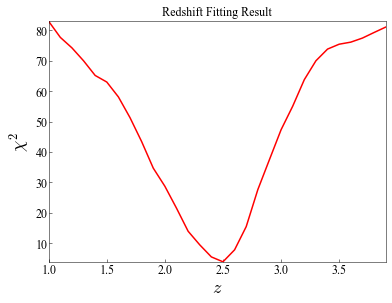

In [10]:
# Plot;
plt.plot(zspace,chi2s[:,1])
plt.ylabel('$\chi^2$',fontsize=18)
plt.xlabel('$z$',fontsize=18)
plt.title('Redshift Fitting Result')
#plt.ylim(0,120)

In [11]:
# Get z at the chi2 minimum.
izfit = np.argmin(chi2s[:,1])
zfit = zspace[izfit]
print('zfit is %.2f'%(zfit))

zfit is 2.50


In [18]:
# Use chi2 as a prior
# User can provide phot-z prob by EAZY too.
prior = {}
prior['z'] = zspace
prior['chi2'] = chi2s[:,1]
#prior
#chi2s.shape

In [19]:
# Or arbitrary prior;
if False:
    # Or define a new prior:
    zspace_tmp = np.arange(0,13,0.01)
    chi2s_tmp = zspace_tmp * 0 + 99
    con_tmp = (zspace_tmp>1.8) & (zspace_tmp<2.1)
    chi2s_tmp[con_tmp] = 1.0

    prior = {}
    prior['z'] = zspace_tmp
    prior['chi2'] = chi2s_tmp

In [20]:
# Repeat the quick fit at the proposed redshift;
inputs['ZGAL'] = zfit
inputs['NMCZ'] = 30

# Update with a new z input
mb = run_gsf_template(inputs, fplt=fplt)

mb.zprev = mb.zgal
out, fm_tmp, xm_tmp = mb.quick_fit(mb.zgal, mb.Cz0, mb.Cz1)


Metallicity evolution is off.
No. of params are : 13
No FIR is implemented.
############################
Making templates at z=2.5000
############################
Template resolution is unknown.
Set to 50.0 km/s.
Templates convolution (intrinsic morphology).
Template convolution with Moffat.
########################
### Fitting Function ###
########################
READ data with Cz0=1.00, Cz0=1.00, zgal=2.50
At this redshift, A9 is beyond the age of universe and not used.
Dust is set in [0.0:4.0]/mag. Initial value is set to 0.5
Start quick fit;



#####################################
Zbest, chi are; 0 4.97677513
Params are; [[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 3287
    # data points      = 232
    # variables        = 11
    chi-square         = 1099.86730
    reduced chi-square = 4.97677513
    Akaike info crit   = 383.040128
    Bayesian info crit = 420.954239
##  Warning: uncertainties could not be estimated:
    this fitting method doe

### Now the result looks good

Text(0, 0.5, 'Flux (MJy/sr)')

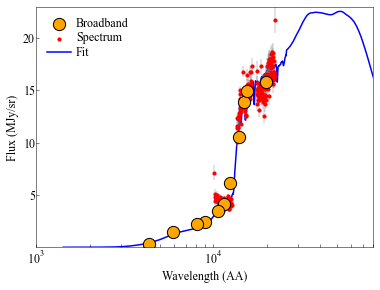

In [21]:
plt.close()

# Plot the result;
flux_all, wave_all = mb.fnc.tmp04_val(out, mb.zgal, mb.lib_all)

# Template
plt.errorbar(wave_all, flux_all, ls='-', color='b', zorder=0, label='Fit')

# plot;
plt.scatter(dict['xbb'], dict['fybb'], marker='o', c='orange', edgecolor='k', s=150, zorder=2, alpha=1, label='Broadband')

if True: # Spec data;
    plt.errorbar(dict['x'], dict['fy'], yerr=dict['ey'], ls='', color='gray', zorder=1, alpha=0.3)
    plt.scatter(dict['x'], dict['fy'], marker='o', color='r',edgecolor='r', s=10, zorder=1, alpha=1, label='Spectrum')

plt.xlim(1000,80000)
#plt.ylim(0,25)
plt.xscale('log')

plt.legend(loc=2)
plt.xlabel('Wavelength (AA)')
plt.ylabel('Flux (MJy/sr)')

### Now fit redshift in more details;

In [22]:
dict = mb.read_data(mb.Cz0, mb.Cz1, mb.zgal)

# By usinng the bbest fit template above;
con_tmp = () #(7000 < wave_all) & (wave_all < 25000)
xm_tmp = wave_all[con_tmp]
fm_tmp = flux_all[con_tmp]

# Update inputs; 
inputs['NMCZ'] = 300
inputs['NWALKZ'] = 30
mb.update_input(inputs)

# Redshift fit when BB photometry only?
f_bb_zfit = True

# This works only when spectrum is provided.
mb.fit_redshift(dict, xm_tmp, fm_tmp, delzz=0.01, zliml=2., zlimu=2.55, ezmin=0.01, snlim=0, \
                f_bb_zfit=f_bb_zfit, priors=prior)


  3%|▎         | 8/300 [00:00<00:03, 78.53it/s]

READ data with Cz0=1.00, Cz0=1.00, zgal=2.50
Metallicity evolution is off.
No. of params are : 13
############################
Start MCMC for redshift fit
############################


100%|██████████| 300/300 [00:03<00:00, 82.20it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 6;
tau: [22.59278034 18.3713302  20.76864243]



Recommended redshift, Cz0 and Cz1, 2.49697 1.00260 0.99917, with chi2/nu=4.378





'y'

In [23]:
# This is normalization;
# Should be ~1, as we have already normalized the spectra to BB fluxes.
print('Redshift 16/50/84th percentile range :',mb.z_cz)
print(mb.Czrec0)
print(mb.Czrec1)

Redshift 16/50/84th percentile range : [2.49532154 2.49696618 2.49992725]
1.0026016064722085
0.9991747460259703


Figure is saved in ./output/zprob_00003_PA00.png


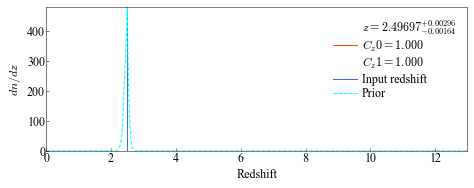

In [24]:
# Take a look at z distribution
fig_zdist, ax1 = mb.get_zdist(f_interact=True)


In [25]:
#%matplotlib inline

#import matplotlib as mpl
#mpl.use('TkAgg')

ax1.set_xlim(2.,3.)
fig_zdist.savefig('zprob_00003_PA00.png')
fig_zdist.show()

/Users/tmorishita/anaconda3/envs/gsf/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


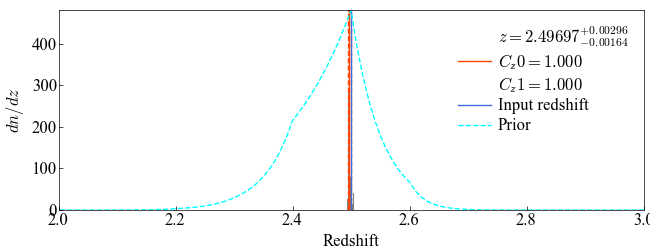

In [26]:
from IPython.display import Image 
Image("zprob_00003_PA00.png")

In [27]:
mb.zgal

2.5000000000000013

### Now, run the whole SED fitting;

Metallicity evolution is off.
No. of params are : 13
########################
### Fitting Function ###
########################
READ data with Cz0=1.00, Cz0=1.00, zgal=2.50
At this redshift, A9 is beyond the age of universe and not used.
Dust is set in [0.0:4.0]/mag. Initial value is set to 0.5



#####################################
Zbest, chi are; 0 3.27127629
Params are; [[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 3841
    # data points      = 232
    # variables        = 11
    chi-square         = 722.952059
    reduced chi-square = 3.27127629
    Akaike info crit   = 285.692485
    Bayesian info crit = 323.606596
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    A0: -19.8113485 (init = 0)
    A1: -4.2

  0%|          | 4/1000 [00:00<00:28, 35.08it/s]

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 3238
    # data points      = 232
    # variables        = 12
    chi-square         = 793.765911
    reduced chi-square = 3.60802687
    Akaike info crit   = 309.371884
    Bayesian info crit = 350.732732
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    A0:  -1.08692014 (init = 0)
    A1:  -1.05113558 (init = 0)
    A2:   1.22908692 (init = 0)
    A3:   0.99445940 (init = 0)
    A4:   0.23669741 (init = 0)
    A5:  -0.13169622 (init = 0)
    A6:  -0.78154466 (init = 0)
    A7:  -0.13747824 (init = 0)
    A8:  -3.28745957 (init = 0)
    A9:  -20 (fixed)
    Av:   0.33291228 (init = 0.5)
    Z0:   0.57812087 (init = 0.6)
    zmc:  2.49722946 (init = 2.496966)



##

100%|██████████| 1000/1000 [00:20<00:00, 47.76it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 12 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [121.56726565 106.24864951 108.71214428 113.14542238 106.56456608
 105.6278967  109.47134619 101.65386639 107.75563507 105.3205017
  98.4025823   77.2623268 ]
###############################
### MCMC part took 21.1 sec ###
###############################
 => Saving data to cpklfile ./output/chain_00003_PA00_corner.cpkl
##########################
### Writing parameters ###
##########################


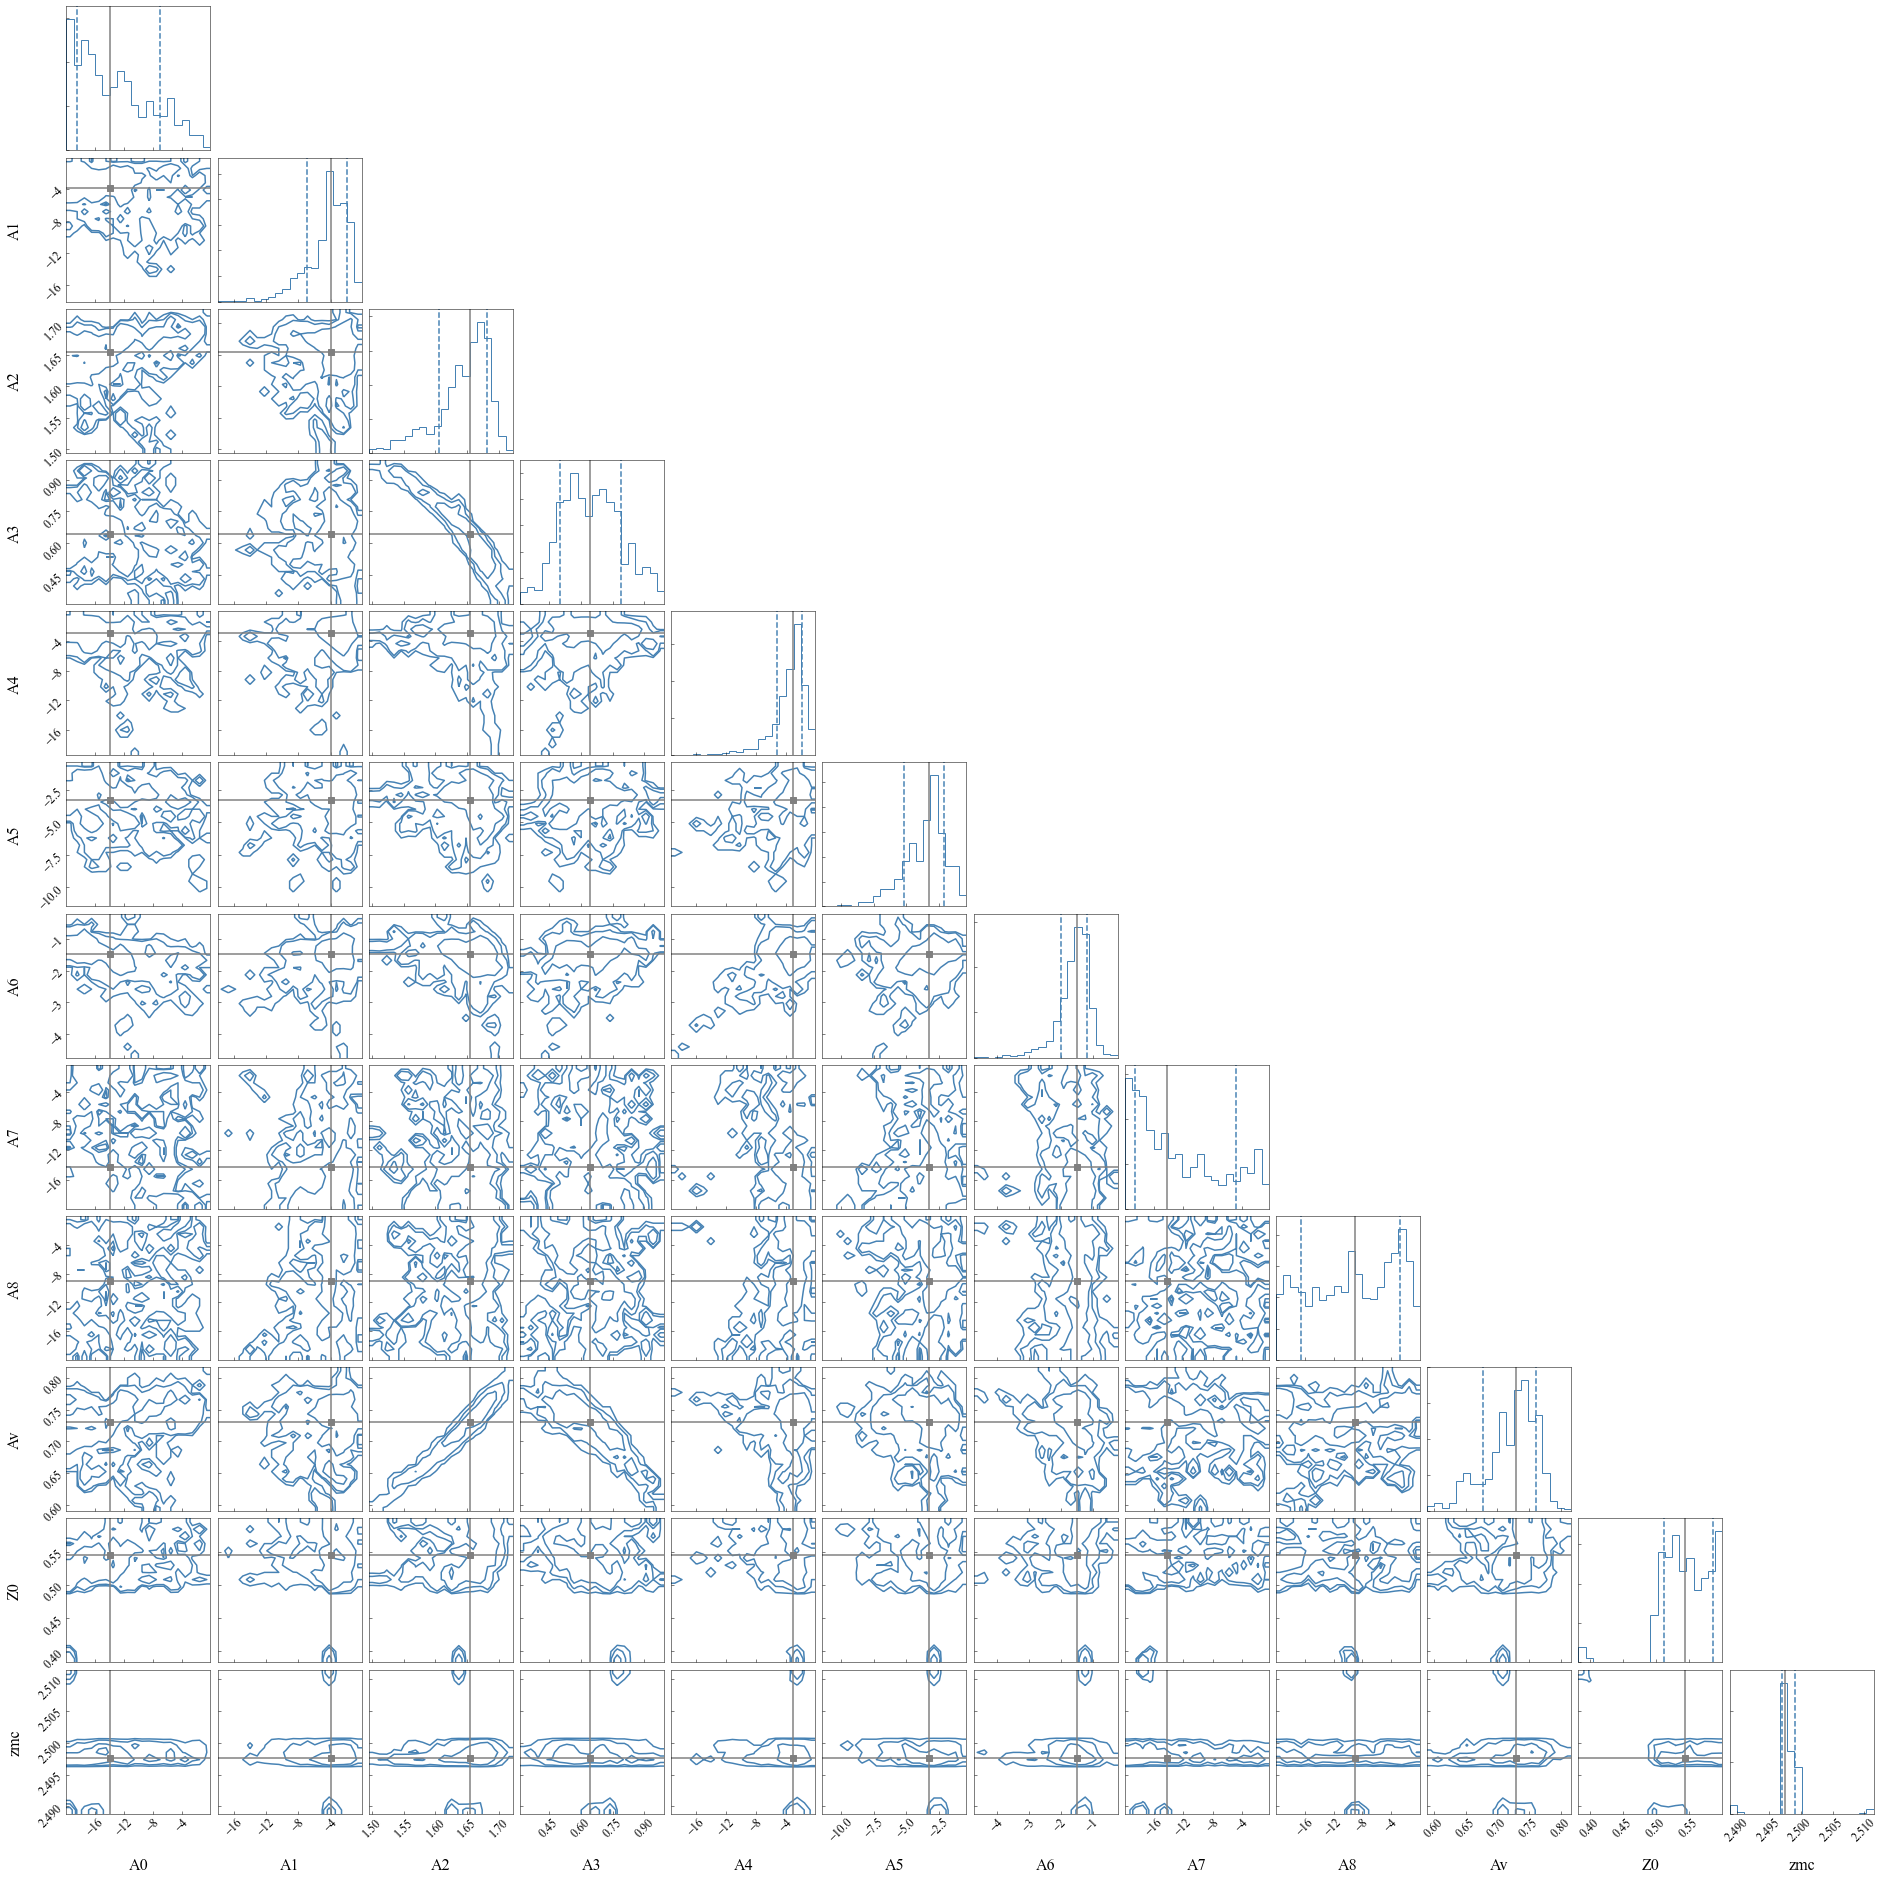

In [28]:
# No interactive fit;
inputs['ZMC'] = 1
inputs['ZVIS'] = 0
inputs['NMC'] = 1000
inputs['ZGAL'] = mb.z_cz[1]

# Update inputs; 
mb.update_input(inputs)

# Since already z-fit done, we can skip z-fit;
skip_fitz = True

# Main;
flag_suc = mb.main(cornerplot=True, specplot=1, sigz=1.0, ezmin=0.01, ferr=0, f_move=False, skip_fitz=skip_fitz)


Progress: |███████████████████████████████████████-| 99.9% Complete (999/1000)
SFMS is shifted to Salpeter IMF.
SFMS is shifted to Salpeter IMF.
SFMS is shifted to Salpeter IMF.
Rejuvenation judge failed. (plot_sfh.py)


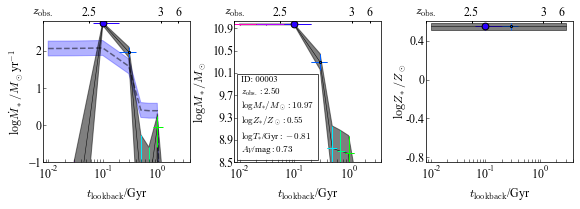

In [29]:
# Plot SFH;

# Plot Starforming Main Sequence from Speagle+14?
f_SFMS = True

plot_sfh(mb, f_comp=mb.ftaucomp, fil_path=mb.DIR_FILT,
inputs=mb.inputs, dust_model=mb.dust_model, DIR_TMP=mb.DIR_TMP, f_SFMS=f_SFMS, f_fill=True)

READ data with Cz0=1.00, Cz0=1.00, zgal=2.50
This function (write_lines) needs to be revised.
Median SN at 3400-3800 is; 15.246613372430922
Median SN at 4200-5000 is; 26.2204279886239


/Users/tmorishita/anaconda3/envs/gsf/lib/python3.7/site-packages/gsf-1.4-py3.7.egg/gsf/plot_sed_logA.py:1550: UserWarning: loadtxt: Empty input file: "./output/table_00003_PA00_lines.txt"
  fl = np.loadtxt(DIR_OUT + 'table_' + ID + '_PA' + PA + '_lines.txt', comments='#')


Progress: |███████████████████████████████████████-| 99.7% Complete (299/300)




No-of-detection    : 232
chi2               : 363.91
No-of-non-detection: 0
chi2 for non-det   : -0.00
No-of-params       : 12
Degrees-of-freedom : 220
Final chi2/nu      : 1.65


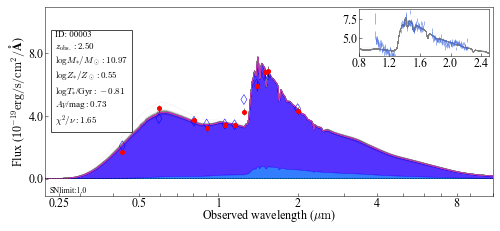

In [30]:
# Plot SED;
plot_sed(mb, fil_path=mb.DIR_FILT,
figpdf=False, save_sed=True, inputs=mb.inputs, mmax=300,
f_fill=True, dust_model=mb.dust_model, DIR_TMP=mb.DIR_TMP, f_label=True)


Total stellar mass is 9.34e+10
READ data with Cz0=1.00, Cz0=1.00, zgal=2.50


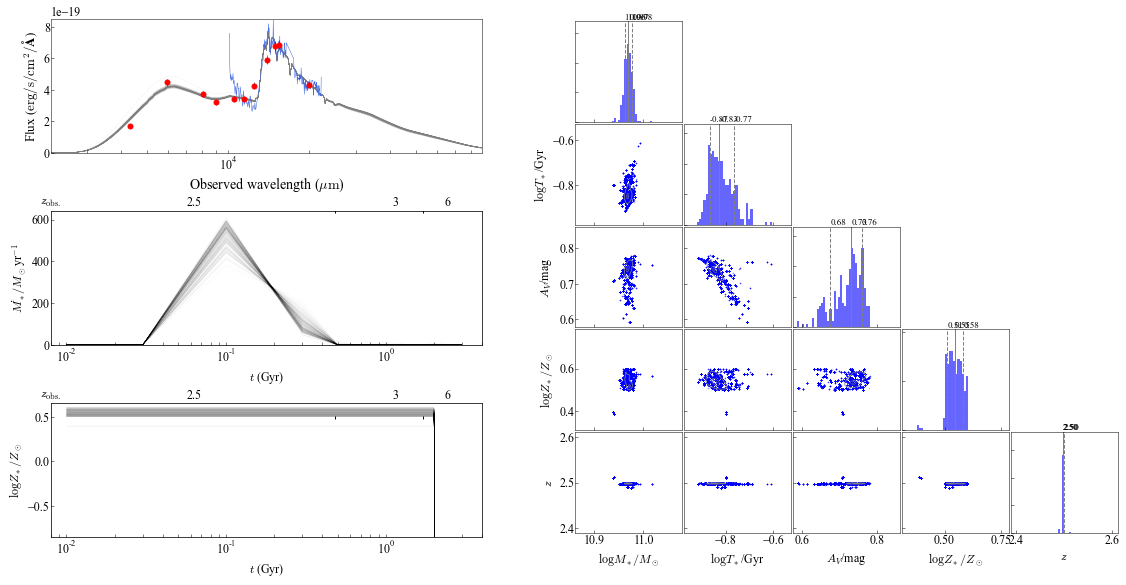

In [31]:
# Physical parameters;
plot_corner_physparam_summary(mb)